In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import seaborn as sns

In [4]:
# 读取数据
data = pd.read_csv(r"F:\cache_data\pre_property_table\dy\feature_ph_dy.csv")
print(len(data))
# 删除有缺失值的行
# data.dropna(inplace=True)
# len(data),data.columns
# 选择数值列并计算它们的均值
numeric_cols = data.select_dtypes(include=[np.number])
means = numeric_cols.mean()
# 使用均值填充每个数值列的缺失值
data[numeric_cols.columns] = data[numeric_cols.columns].fillna(means)
len(data),data.columns

1159


(1159,
 Index(['ph', 'ylzjhl', 'yjz', 'qdan', 'qlin', 'qjia', 'qxi', 'yxlin', 'sxjia',
        'hxjia', 'yxliu', 'yxgui', 'yxtie', 'yxmeng', 'yxtong', 'yxxing',
        'yxpeng', 'yxmu', 'zgong', 'zshen', 'zqian', 'zge', 'zge2', 'znie',
        'jxzc11', 'jxzc12', 'jxzc13', 'jxzc14', 'ph_Status', 'ylzjhl_Status',
        'yjz_Status', 'qdan_Status', 'qlin_Status', 'qjia_Status', 'qxi_Status',
        'yxlin_Status', 'sxjia_Status', 'hxjia_Status', 'yxliu_Status',
        'yxgui_Status', 'yxtie_Status', 'yxmeng_Status', 'yxtong_Status',
        'yxxing_Status', 'yxpeng_Status', 'yxmu_Status', 'zgong_Status',
        'zshen_Status', 'zqian_Status', 'zge_Status', 'zge2_Status',
        'znie_Status', 'jxzc11_Status', 'jxzc12_Status', 'jxzc13_Status',
        'jxzc14_Status', 'DEM', 'AnalyticalHillshading', 'Aspect',
        'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
        'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'MRRTF', 'MRVBF',
        'PlanCurvature', 'ProfileCu

In [5]:
label_list = ['ph', 'ylzjhl', 'yjz', 'qdan', 'qlin', 'qjia', 'qxi', 'yxlin', 'sxjia',
        'hxjia', 'yxliu', 'yxgui', 'yxtie', 'yxmeng', 'yxtong', 'yxxing',
        'yxpeng', 'yxmu', 'zgong', 'zshen', 'zqian', 'zge', 'zge2', 'znie',
        'jxzc11', 'jxzc12', 'jxzc13', 'jxzc14']
features_list  = ['DEM', 'AnalyticalHillshading', 'Aspect',
        'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
        'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'MRRTF', 'MRVBF',
        'PlanCurvature', 'ProfileCurvature', 'RelativeSlopePosition', 'Slope',
        'TopographicWetnessIndex', 'TotalCatchmentArea', 'ValleyDepth',
        'NIGHT2022', 'ETP2022_mean', 'TMP2022_mean', 'PRE2022_mean',
        'PRE2022_3', 'PRE2022_11', 'ETP2022_3', 'ETP2022_11', 'TMP2022_3',
        'TMP2022_11', 'evi', 'lswi', 'mndwi', 'ndmi', 'ndvi', 'ndwi', 'PCA_0',
        'PCA_1', 'savi', 'vari', 'DL', 'DZ','SlopeClass','LON', 'LAT']

In [6]:
duplicates = data.duplicated(subset=list(data.columns)[1:], keep='first')
df_duplicates = data[duplicates]
df_duplicates

,ph,ylzjhl,yjz,qdan,qlin,qjia,qxi,yxlin,sxjia,hxjia,...,ndwi,PCA_0,PCA_1,savi,vari,DL,DZ,LON,LAT,SlopeClass


In [5]:
# 去除重复数据
data.drop_duplicates(subset=list(data.columns)[1:], keep='first', inplace=True)

In [6]:
data

,ph,ylzjhl,yjz,qdan,qlin,qjia,qxi,yxlin,sxjia,hxjia,...,ndwi,PCA_0,PCA_1,savi,vari,DL,DZ,LON,LAT,SlopeClass
0,5.30,6.33,27.60,1.52,0.49,4.52,0.2200,19.5000,94.0,88.0000,...,-0.593337,0.144017,0.068568,0.434746,0.174145,13,2,423585.0,2891090.0,1
1,6.00,6.40,17.40,1.09,0.28,3.52,0.1500,28.7000,94.1,77.7000,...,-0.579832,0.164497,0.080262,0.429757,0.189109,13,7,435385.0,2901755.0,2
2,4.38,5.64,17.50,0.73,0.11,4.29,0.4300,3.3900,61.2,98.0000,...,-0.765559,-0.068682,-0.074368,0.426341,0.417362,3,3,469330.0,2899265.0,4
3,4.68,14.90,46.80,2.28,0.32,7.90,0.8600,3.9900,95.1,171.0000,...,-0.707025,-0.043486,-0.025812,0.414616,0.384712,3,2,457710.0,2885820.0,4
4,7.04,14.20,51.30,3.01,0.53,24.30,0.2500,5.8200,112.0,306.0000,...,-0.589759,0.031788,0.048853,0.389160,0.181265,13,2,442105.0,2909305.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,4.97,12.60,64.90,2.67,0.32,1.29,0.0001,10.2000,70.0,0.0001,...,-0.681265,0.056622,-0.003617,0.437431,0.231419,3,2,415245.0,2885265.0,4
1155,6.42,27.50,62.80,3.55,0.68,25.60,0.0001,0.7200,139.0,0.0001,...,-0.703704,-0.028655,-0.020768,0.450374,0.328063,1,1,450570.0,2875940.0,1
1156,6.02,24.10,8.11,0.79,0.31,11.10,0.0001,0.0001,50.0,0.0001,...,-0.685385,-0.066180,-0.032688,0.405130,0.427907,3,3,459370.0,2898965.0,4
1157,5.78,22.10,89.40,4.09,0.57,22.50,0.0001,9.2700,314.0,0.0001,...,-0.743302,0.016543,-0.013957,0.468419,0.306215,3,1,461995.0,2909820.0,2


In [7]:
data['DL'] = data['DL'].astype("category")
data['DZ'] = data['DZ'].astype("category")
data['SlopeClass'] = data['SlopeClass'].astype("category")
# data['TDQS'] = data['TDQS'].astype("category")
data.dtypes

ph             float64
ylzjhl         float64
yjz            float64
qdan           float64
qlin           float64
                ...   
DL            category
DZ            category
LON            float64
LAT            float64
SlopeClass    category
Length: 98, dtype: object

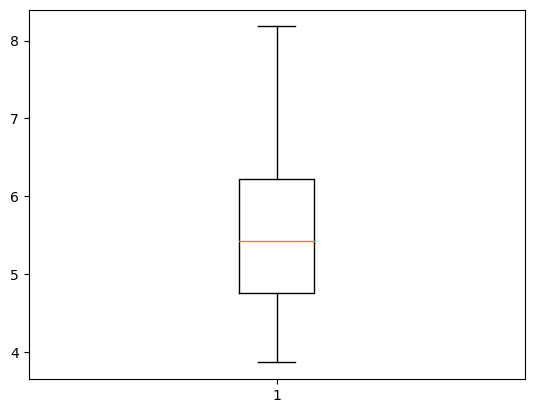

(1159, 98)


In [8]:
plt.boxplot(data["ph"])
plt.show()
print(data.shape)

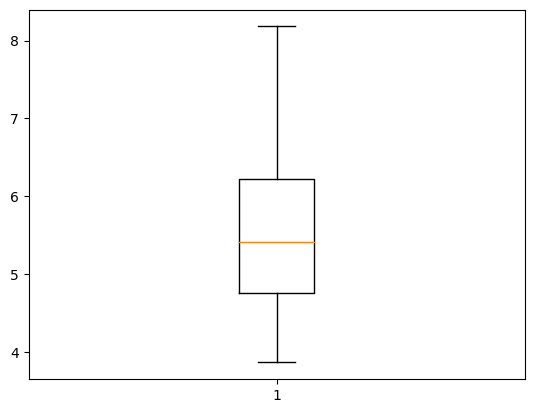

(1135, 33)


In [18]:
# 剔除离群值（Z-score）
z_scores = (data["ph"]-data["ph"].mean())/data["ph"].std()
z_scores.describe()
# 设置阈值
z_score_filter= 3
z_filter_data = data[z_scores<z_score_filter]
z_filter_data
plt.boxplot(z_filter_data["ph"])
plt.show()
print(z_filter_data.shape)

In [1]:
# 
label_index = 1
print(label_list[label_index])

NameError: name 'label_list' is not defined

In [10]:
temp_data = data[[label_list[label_index]]+features_list]

In [11]:
temp_data.head(1)

,ph,DEM,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,LSFactor,MRRTF,...,ndwi,PCA_0,PCA_1,savi,vari,DL,DZ,SlopeClass,LON,LAT
0,5.3,1051.0,0.785191,5.892578,1059.0334,0.000122,8.033569,-25.103483,0.016043,0.000409,...,-0.593337,0.144017,0.068568,0.434746,0.174145,13,2,1,423585.0,2891090.0


In [12]:
# 划分测试数据
train_data,test_data = train_test_split(temp_data,test_size=0.2,random_state=0)
train_data.shape,test_data.shape

((927, 43), (232, 43))

In [13]:
label = label_list[label_index]
train_data[label].describe()

count    927.000000
mean       5.585609
std        1.002183
min        3.910000
25%        4.760000
50%        5.400000
75%        6.215000
max        8.180000
Name: ph, dtype: float64

In [14]:
hyperparameters={
	'NN_TORCH': {},
	'FASTAI': {},
	'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}]
}

In [17]:
# TabularPredictor.load("AutogluonModels\ag-20230802_083815\")  全要素
# TabularPredictor.load("AutogluonModels\ag-20230803_041226\")  全要素  presets="best_quality"

# predictor = TabularPredictor(label=label).fit(train_data,time_limit=6000,presets="best_quality")
# predictor = TabularPredictor.load(r"AutogluonModels\ag-20230803_041226")

# 模型存放位置
model_path = r"D:\temp_model"
# model_path = r'D:\ArcgisData\pred_organic\organic_pred_moudle\对数化'
predictor = TabularPredictor(label=label,path=model_path,eval_metric='r2',problem_type='regression')
# predictor.fit(train_data,time_limit=10800,presets="best_quality",num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor.fit(train_data,time_limit=30800,num_stack_levels = 10,num_bag_folds = 5,num_bag_sets = 30,hyperparameters=hyperparameters,presets="best_quality")
# predictor = TabularPredictor.load(model_path)
predictor.fit(train_data,time_limit=20000,presets="best_quality",hyperparameters=hyperparameters)
# predictor.fit(train_data,time_limit=20000,presets="good_quality")

Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 20000 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: D:\temp_model\ds_sub_fit\sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 29 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 19971 seconds.
Star

In [18]:
# 获取最佳模型
best_model = predictor.get_model_best()
print(best_model)

# 获取模型的训练摘要
predictor.fit_summary()

WeightedEnsemble_L3
*** Summary of fit() ***
Estimated performance of each model:
                    model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3   0.301624          r2       0.280023  21.739297                0.000000           0.031256            3       True         10
1     WeightedEnsemble_L2   0.296508          r2       0.079983  11.299515                0.000000           0.015655            2       True          5
2   NeuralNetTorch_BAG_L1   0.274589          r2       0.031916   7.571856                0.031916           7.571856            1       True          4
3   NeuralNetTorch_BAG_L2   0.257773          r2       0.197671  17.483599                0.083329           5.651036            2       True          9
4    ExtraTreesMSE_BAG_L2   0.255399          r2       0.150312  12.177958                0.035971           0.345395            2       True          7


C:\Users\Runker\AppData\Local\Temp\ipykernel_21036\3741503116.py:2: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model = predictor.get_model_best()


{'model_types': {'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'NeuralNetTorch_BAG_L2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'RandomForestMSE_BAG_L1': 0.21005892722943065,
  'ExtraTreesMSE_BAG_L1': 0.2305156594888238,
  'NeuralNetFastAI_BAG_L1': 0.21051849743674944,
  'NeuralNetTorch_BAG_L1': 0.27458865525661225,
  'WeightedEnsemble_L2': 0.29650798753843355,
  'RandomForestMSE_BAG_L2': 0.25309723455781497,
  'ExtraTreesMSE_BAG_L2': 0.2553990522787942,
  'NeuralNetFastAI_BAG_L2': 0.22

In [19]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))
y_test = test_data[label]
# 训练数据
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]
# 计算残差
residuals_test =y_train - y_train_pred

In [20]:
predictor.leaderboard(train_data, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE_BAG_L1,0.897098,0.230516,r2,0.068624,0.034471,0.345947,0.068624,0.034471,0.345947,1,True,2
1,RandomForestMSE_BAG_L1,0.893801,0.210059,r2,0.072624,0.034359,0.548703,0.072624,0.034359,0.548703,1,True,1
2,RandomForestMSE_BAG_L2,0.672462,0.253097,r2,0.391823,0.161268,12.456247,0.067605,0.046926,0.623684,2,True,6
3,ExtraTreesMSE_BAG_L2,0.656078,0.255399,r2,0.388534,0.150312,12.177958,0.064316,0.035971,0.345395,2,True,7
4,WeightedEnsemble_L2,0.606757,0.296508,r2,0.251594,0.079983,11.299515,0.000000,0.000000,0.015655,2,True,5
5,WeightedEnsemble_L3,0.556465,0.301624,r2,0.575270,0.280023,21.739297,0.000000,0.000000,0.031256,3,True,10
6,NeuralNetFastAI_BAG_L2,0.511801,0.226537,r2,0.408060,0.149767,15.433322,0.083842,0.035426,3.600758,2,True,8
7,NeuralNetFastAI_BAG_L1,0.498872,0.210518,r2,0.081482,0.013596,3.366058,0.081482,0.013596,3.366058,1,True,3
8,NeuralNetTorch_BAG_L2,0.496202,0.257773,r2,0.423822,0.197671,17.483599,0.099605,0.083329,5.651036,2,True,9
9,NeuralNetTorch_BAG_L1,0.475294,0.274589,r2,0.101487,0.031916,7.571856,0.101487,0.031916,7.571856,1,True,4


In [21]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.245881,0.301624,r2,0.383523,0.280023,21.739297,0.000000,0.000000,0.031256,3,True,10
1,WeightedEnsemble_L2,0.243494,0.296508,r2,0.165772,0.079983,11.299515,0.000000,0.000000,0.015655,2,True,5
2,ExtraTreesMSE_BAG_L2,0.238156,0.255399,r2,0.268418,0.150312,12.177958,0.050150,0.035971,0.345395,2,True,7
3,RandomForestMSE_BAG_L1,0.233546,0.210059,r2,0.052496,0.034359,0.548703,0.052496,0.034359,0.548703,1,True,1
4,NeuralNetTorch_BAG_L2,0.230486,0.257773,r2,0.284140,0.197671,17.483599,0.065872,0.083329,5.651036,2,True,9
5,RandomForestMSE_BAG_L2,0.229253,0.253097,r2,0.269524,0.161268,12.456247,0.051256,0.046926,0.623684,2,True,6
6,NeuralNetFastAI_BAG_L2,0.227561,0.226537,r2,0.266395,0.149767,15.433322,0.048126,0.035426,3.600758,2,True,8
7,NeuralNetTorch_BAG_L1,0.220807,0.274589,r2,0.068022,0.031916,7.571856,0.068022,0.031916,7.571856,1,True,4
8,NeuralNetFastAI_BAG_L1,0.217413,0.210518,r2,0.050041,0.013596,3.366058,0.050041,0.013596,3.366058,1,True,3
9,ExtraTreesMSE_BAG_L1,0.215849,0.230516,r2,0.047710,0.034471,0.345947,0.047710,0.034471,0.345947,1,True,2


In [19]:

# 训练集指标
train_metrics = predictor.leaderboard(train_data, silent=True) 

# 测试集指标
test_metrics = predictor.leaderboard(test_data, silent=True)

# 获取指标名称
metric_name = list(train_metrics.keys())[0]  


In [20]:
pd_train = train_metrics[['model','score_test']]
pd_test = test_metrics[['model','score_test']]
pd_result = pd.merge(pd_train,pd_test,on='model')

In [21]:
pd_result
pd_result.rename(columns = {"model":"Model","score_test_x":"Train Set","score_test_y":"Test  Set"},inplace=True)

In [22]:
pd_result

,Model,Train Set,Test Set
0,ExtraTreesMSE,0.737691,0.169102
1,RandomForestMSE,0.736204,0.125465
2,XGBoost,0.722622,0.077361
3,CatBoost,0.629732,0.196780
4,LightGBMLarge,0.603241,0.090862
5,WeightedEnsemble_L2,0.549726,0.189265
6,KNeighborsDist,0.520687,-0.343400
7,LightGBMXT,0.504282,0.180322
8,NeuralNetFastAI,0.417056,0.087020
9,NeuralNetTorch,0.333887,0.091661


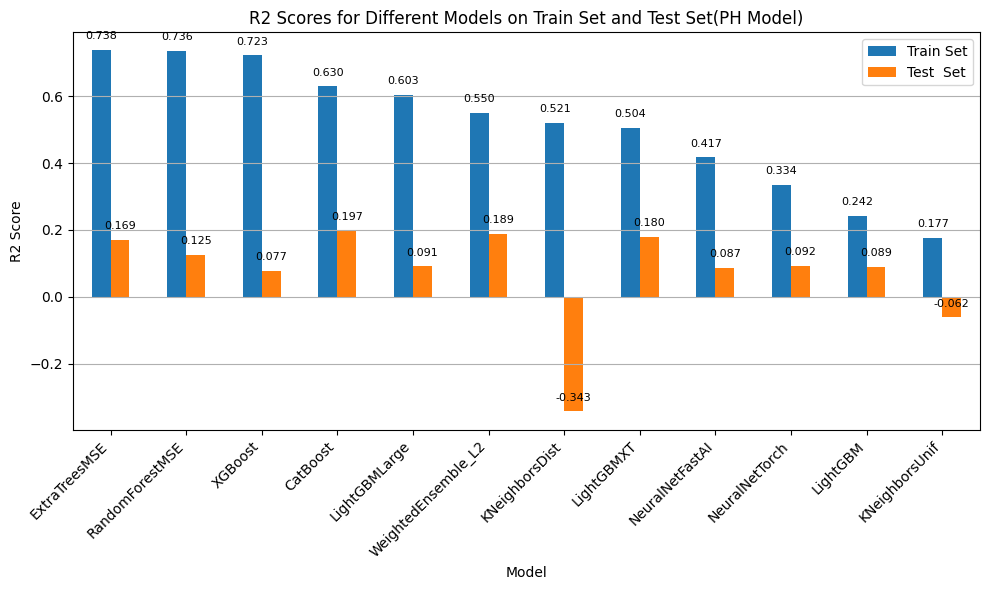

In [23]:
ax = pd_result.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title('R2 Scores for Different Models on Train Set and Test Set(PH Model)')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# 添加数值标签
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points',fontsize=8, 
                )

plt.tight_layout()
plt.show()


In [24]:
# 克里金残差训练
OK = OrdinaryKriging(train_data['LON'], train_data['LAT'], residuals_test, variogram_model='spherical')  #variogram_model:linear,gaussian,exponential,spherical
kriging_predictions_test, _ = OK.execute('points', test_data['LON'], test_data['LAT'])
predictions_test = y_test_pred + kriging_predictions_test
# 计算R2
r2 = r2_score(y_test, predictions_test)
r2

0.1934814683880981

In [26]:
test_data.describe()

,pH,DEM,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,LSFactor,PlanCurvature,...,SecondMoment,Variance,PRE,SRA,TMP,VAP,WIND,BIO,LON,LAT
count,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,...,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1.169000e+03
mean,5.682960,953.011548,0.815580,3.201213,945.228524,9.946194,16.557011,-1.277616,10.377718,-0.000892,...,0.361805,0.555651,100.415170,12967.240172,15.290968,1.507156,1.706401,192.282639,448477.754491,2.893395e+06
std,0.823179,168.321022,0.181265,1.690291,166.426609,14.631767,7.916327,7.818409,12.961770,0.007143,...,0.218904,0.781466,1.247797,95.961867,0.698703,0.059285,0.086447,1.690938,16337.853237,1.509309e+04
min,3.970000,502.700000,0.019378,0.001729,500.735440,-0.700012,0.001953,-66.627310,0.000325,-0.046756,...,0.111111,0.000000,96.750000,12674.333000,12.566667,1.280000,1.550000,186.959170,411620.000000,2.860765e+06
25%,5.090000,846.000000,0.730667,1.892486,837.746500,0.292725,16.320465,-2.389420,2.140678,-0.002453,...,0.209877,0.172840,99.750000,12904.667000,14.975000,1.479167,1.658333,191.331160,436505.000000,2.882145e+06
50%,5.510000,918.400000,0.795203,3.197076,912.807860,3.501892,16.320465,-0.093183,6.617772,-0.000004,...,0.283951,0.246914,100.333336,12982.083000,15.433333,1.518333,1.691667,192.254700,448755.000000,2.892820e+06
75%,6.130000,1027.100000,0.906595,4.547174,1030.303700,14.204651,16.320465,1.496167,13.620165,0.001680,...,0.432099,0.666667,101.083336,13033.333000,15.741667,1.545833,1.741667,193.242750,460815.000000,2.904860e+06
max,8.560000,1677.100000,1.627249,6.283186,1634.727500,119.998474,79.084110,63.107530,146.893130,0.037513,...,1.000000,7.333334,104.583336,13199.750000,17.008333,1.658333,2.066667,197.757220,477925.000000,2.924220e+06


In [27]:
# 重新计算预测值

def calc_predict_value(actual_value, predict_value):
    diff = np.abs(actual_value - predict_value)/actual_value
    modified_diff = np.where(diff <= 0.15, actual_value, predict_value)
    return modified_diff


In [28]:
t_pred = calc_predict_value(test_data[label],y_test_pred)
t_pred

array([5.4       , 5.65      , 6.67      , ..., 4.88      , 5.1       ,
       6.28680086])

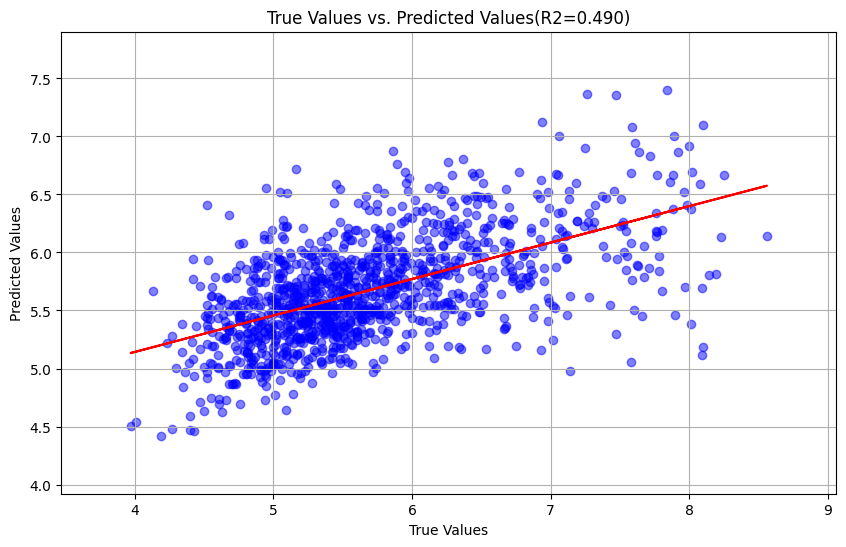

In [30]:
# plt.scatter(y_test, predictions_test)

# # 添加标签和标题
# plt.xlabel('True Values')
# plt.ylabel('Predicted Values')
# plt.title('True Values vs. Predicted Values')

# # 显示图表
# plt.show()
# 画图
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions_test, c='b', alpha=0.5)

fit = np.polyfit(y_test, predictions_test, deg=1)
fit_fn = np.poly1d(fit) 
plt.plot(y_test, fit_fn(y_test), c='r')

plt.xlim([min(y_test)-0.5, max(y_test)+0.5])
plt.ylim([min(predictions_test)-0.5, max(predictions_test)+0.5])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values(R2=0.490)')
plt.grid()

plt.show()

In [ ]:
# 创建折线图
plt.figure(figsize=(52,10))
plt.plot(y_test, label='True Values')
plt.plot(predictions_test, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [32]:
predictor.evaluate(test_data, silent=True)

{'r2': 0.31388551526790487,
 'root_mean_squared_error': -0.6815644647514859,
 'mean_squared_error': -0.46453011961197943,
 'mean_absolute_error': -0.5083805796914471,
 'pearsonr': 0.5616870706349606,
 'median_absolute_error': -0.3856501960754395}

In [33]:
perf = predictor.evaluate_predictions(y_train,y_train_pred,auxiliary_metrics=True,detailed_report=True)

Evaluation: r2 on test data: 0.8308727989438098
Evaluations on test data:
{
    "r2": 0.8308727989438098,
    "root_mean_squared_error": -0.3328442058356216,
    "mean_squared_error": -0.11078526535834562,
    "mean_absolute_error": -0.2380589695817444,
    "pearsonr": 0.9340495183294135,
    "median_absolute_error": -0.17311450004577633
}


In [34]:
perf = predictor.evaluate_predictions(y_test,y_test_pred,auxiliary_metrics=True,detailed_report=True)

Evaluation: r2 on test data: 0.31388551526790487
Evaluations on test data:
{
    "r2": 0.31388551526790487,
    "root_mean_squared_error": -0.6815644647514859,
    "mean_squared_error": -0.46453011961197943,
    "mean_absolute_error": -0.5083805796914471,
    "pearsonr": 0.5616870706349606,
    "median_absolute_error": -0.3856501960754395
}


In [35]:

def calculate_modified_r2(y_true, y_pred):
    diff = np.abs(y_true - y_pred)/y_true
    modified_diff = np.where(diff <= 0.2, 0, np.abs(y_true - y_pred))
    modified_ssr = np.sum(modified_diff**2)
    
    mean = np.mean(y_true)
    total_diff = np.sum((y_true - mean)**2)
    
    r2 = 1 - (modified_ssr / total_diff)
    return r2

print(calculate_modified_r2(test_data[label], y_test_pred))

0.6675832275651417


In [36]:
metrics = predictor.evaluate(test_data, silent=True)

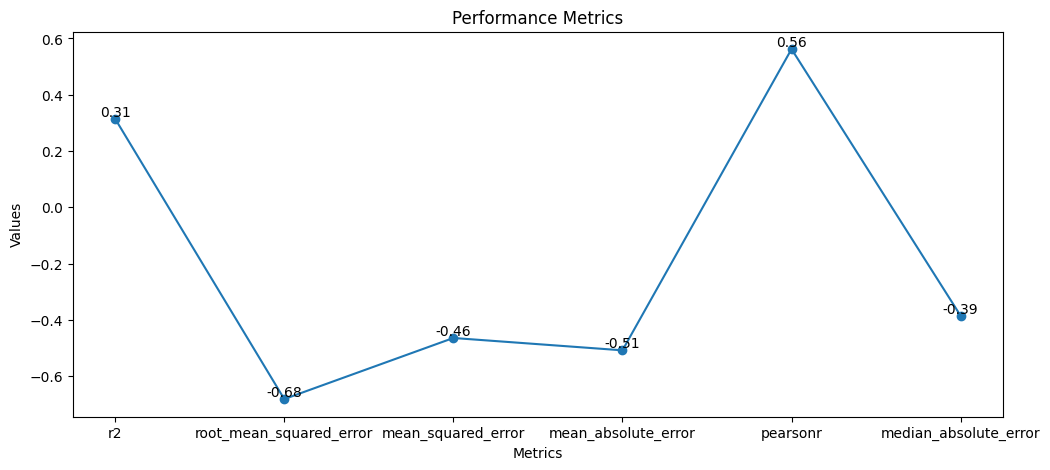

In [37]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(12,5))
plt.plot(metric_names, metric_values, marker='o')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')

# 标注数值
for i in range(len(metric_names)):
    plt.annotate(f'{metric_values[i]:.2f}', (metric_names[i], metric_values[i]), ha='center', va='bottom')

plt.show()


In [55]:
fetures_value = predictor.feature_importance(train_data)
# 将索引添加为列

Computing feature importance via permutation shuffling for 19 features using 4473 rows with 5 shuffle sets...
	39.48s	= Expected runtime (7.9s per shuffle set)
	10.03s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [56]:
df = fetures_value
df.reset_index(level=0, inplace=True)

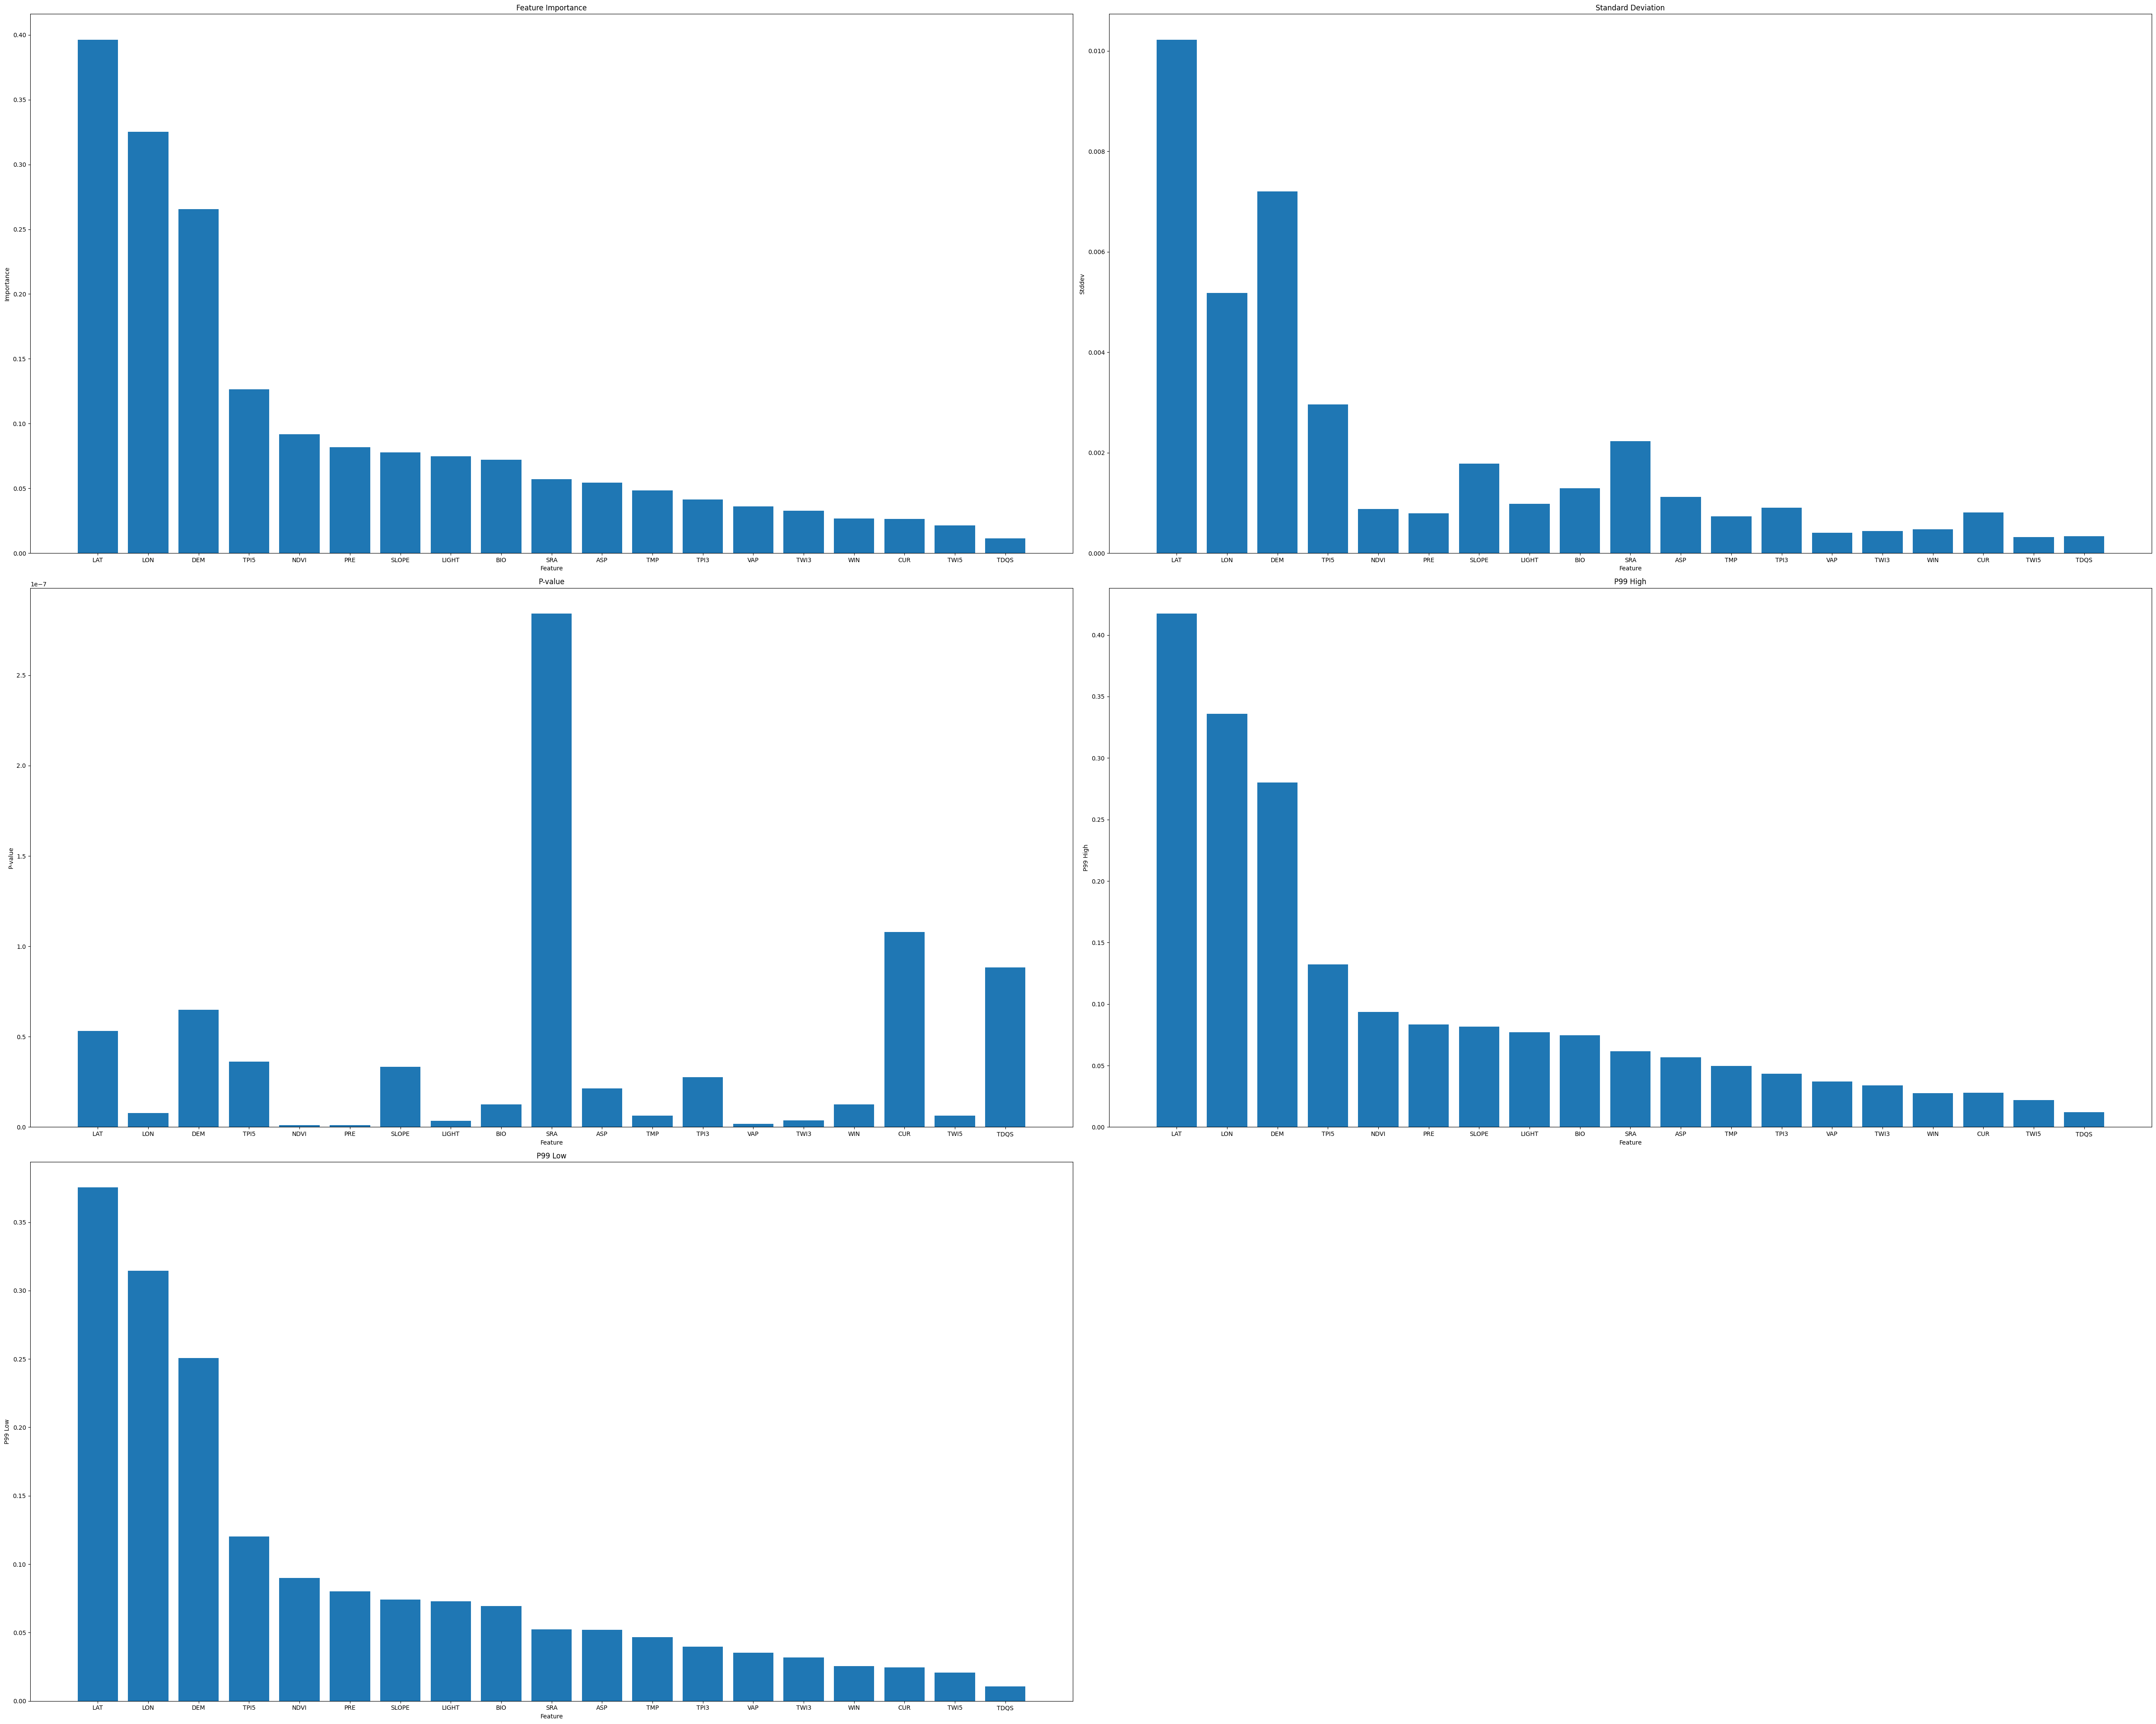

In [57]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(50, 40))

# 绘制各个特征的重要性
plt.subplot(3, 2, 1)
plt.bar(df['index'], df['importance'])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

# 绘制各个特征的标准差
plt.subplot(3, 2, 2)
plt.bar(df['index'], df['stddev'])
plt.title('Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Stddev')

# 绘制各个特征的p值
plt.subplot(3, 2, 3)
plt.bar(df['index'], df['p_value'])
plt.title('P-value')
plt.xlabel('Feature')
plt.ylabel('P-value')

# 绘制各个特征的p99高值
plt.subplot(3, 2, 4)
plt.bar(df['index'], df['p99_high'])
plt.title('P99 High')
plt.xlabel('Feature')
plt.ylabel('P99 High')

# 绘制各个特征的p99低值
plt.subplot(3, 2, 5)
plt.bar(df['index'], df['p99_low'])
plt.title('P99 Low')
plt.xlabel('Feature')
plt.ylabel('P99 Low')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()

In [ ]:
"""importance（重要性）：

取值范围：通常是一个非负实数，可以是介于0到无穷大之间的任意值。
意义：表示该特征对目标变量的预测能力的贡献程度。重要性值越高，说明该特征在预测模型中的影响力越大。
stddev（标准差）：

取值范围：通常是一个非负实数，可以是大于等于0的任意值。
意义：衡量特征值分散程度的统计指标。标准差值越大，表示样本数据在该特征上的波动越大。
p_value（P值）：

取值范围：通常是一个小于等于1的实数，可能是非负实数或者在特定情况下限制在0到1之间的实数。
意义：用于判断某个变量对目标变量是否具有显著影响。较小的p-value表示该特征与目标变量之间的关系更显著。
n（样本数量）：

取值范围：通常是一个正整数，表示用于计算这些特征参数的样本数量。
意义：表示用于计算特征参数的数据样本的数量。
p99_high（99%置信度上限）和p99_low（99%置信度下限）：

取值范围：通常是实数，可以是任意实数或在特定情况下限制在一定范围内的实数。
意义：表示特征的置信区间。在统计意义下，特征取值不会超过上限或低于下限的概率为99%。"""

In [386]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

In [59]:

from sklearn.preprocessing import StandardScaler
# 1. 划分数据为特征（X）和目标（y）
X = data.drop(columns=['pH'])
y = data['pH']

# 2. 划分数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((5112, 19), (1278, 19))

In [61]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

# 建立神经网络模型
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

# 使用模型进行预测
y_pred_nn = model.predict(X_test_scaled)

# 计算 R^2 分数
r2_nn = r2_score(y_test, y_pred_nn)

r2_nn


40/40 [==============================] - 0s 439us/step


0.19366889969938528